In [1]:
import time
import argparse
import numpy as np

import torch
import torch.optim as optim

from utils import normalize,toy_data,norm_embed,nmi_score

import matplotlib.pyplot as plt 

from sklearn.utils import shuffle

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from layers import GraphConvolution, InnerProduct
from utils import norm_embed
import torch

In [3]:
import pandas as pd
import networkx as nx

In [4]:
class GNN(nn.Module):
    
    def __init__(self, batch_size, nfeat, nhid, ndim, mu0, sigma0, fixed):
        super(GNN, self).__init__()

        self.gc1 = GraphConvolution(batch_size, nfeat, nhid, mu0, sigma0, scale=False)
        self.fixed = fixed
        if self.fixed:
            self.embeddings = GraphConvolution(batch_size, nhid, 2*ndim, mu0, sigma0, scale=True)
            self.reconstructions = InnerProduct(2*ndim)
        else:
            self.embeddings = GraphConvolution(batch_size, nhid, 4 * ndim, mu0, sigma0, scale=True)
            self.reconstructions = InnerProduct(4*ndim)
        

    def forward(self, x, adj):
        x = self.gc1(x, adj)

        if self.fixed:
            mu = F.relu(self.reconstructions(x))
            return mu, x
        else:
            lr1, lr2 = torch.chunk(x, chunks=2, dim=2)
            mu = F.relu(self.reconstructions(lr1))
            sigma = F.relu(self.reconstructions(lr2))
            return mu, sigma, x
    

In [5]:
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False,precision=8)

In [6]:
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--seed', type=int, default=426, help='Random seed.')
parser.add_argument('--epochs', type=int, default=500,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.0001,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=10e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')
parser.add_argument('--ndim', type=int, default=2,
                    help='Embeddings dimension.')

args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()

In [7]:
def load_data(cite=False,cora=False,pub=False):
    
    if cite:
        df1 = pd.read_csv('data/citeseer/citeseer.edges')
        df2 = pd.read_csv('data/citeseer/citeseer.node_labels')
        G = nx.from_pandas_edgelist(df1, 'u', 'v','weight',create_using=nx.DiGraph())
        adj_list = np.array([nx.adjacency_matrix(G).todense()], dtype=float)
    
    elif cora:
        df1 = pd.read_csv('data/cora/cora.edges')
        df2 = pd.read_csv('data/cora/cora.node_labels')
        G = nx.from_pandas_edgelist(df1, 'u', 'v','weight',create_using=nx.DiGraph())
        adj_list = np.array([nx.adjacency_matrix(G).todense()], dtype=float)
    
    elif pub:
        df1 = pd.read_csv('data/pubmed/pubmed.edges')
        df2 = pd.read_csv('data/pubmed/pubmed.node_labels')
        G = nx.from_pandas_edgelist(df1, 'u', 'v',create_using=nx.DiGraph())
        adj_list = np.array([nx.adjacency_matrix(G).todense()], dtype=float)
        
    return adj_list

In [8]:
adj = load_data(cite=True)

In [9]:
names = ['Dimension','SVD', 'GNN Fixed Sigma', 'GNN Flexible Sigma']
dims= [10, 20, 30, 40, 50, 60, 70, 80]
res_svd = []
res_fix = []
res_flex = []

In [10]:
def svdApprox(adj,dim,relu=False):
    adj = torch.FloatTensor(adj[0])
    U, S, Vh = torch.linalg.svd(adj)
    mu = torch.matmul(torch.matmul(U[:, :dim], torch.diag(S[:dim])), Vh[:dim, :])
    
    embedx = torch.matmul(U[:, :dim],torch.diag(torch.pow(S[:dim], 0.5)))
    embedy = torch.transpose(torch.matmul(torch.diag(torch.pow(S[:dim], 0.5)),Vh[:dim, :]),0,1)
    
    criterion = torch.nn.GaussianNLLLoss()
    if relu:
        crt = torch.nn.ReLU()
        mu = crt(mu)
    mse = torch.nn.MSELoss()
    mseloss = mse(torch.flatten(mu), torch.flatten(adj))
    sig = torch.sqrt(mseloss)
    sigma = sig * torch.ones(adj.shape)
    loss = criterion(torch.flatten(adj), torch.flatten(mu), torch.flatten(torch.square(sigma)))
    
    return mu,sigma,loss.item(),embedx,embedy

In [11]:
def GraphNeuralNet(adj,dim,fixed=False,new=True,features=None,sig_fix=None):
    
    # Set the random seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
        
    args.ndim = dim
    
    adj_norm = normalize(adj)

    adj = torch.FloatTensor(np.array(adj)).cuda()
    
    # loss function
    criterion = torch.nn.GaussianNLLLoss()
    
    # NULL Model
    mu0 = adj.mean()*torch.ones(adj.shape[1:]).cuda()
    sigma0 = adj.std()*torch.ones(adj.shape[1:]).cuda()
    with torch.no_grad():
        loss0 = criterion(torch.flatten(adj), torch.flatten(mu0), torch.flatten(torch.square(sigma0)))
    
    if new:
        if fixed:
            #svd features
            svd_mu,svd_sig,svd_loss,svdembedx,svdembedy = svdApprox(adj=adj.cpu(),dim=dim)
            features = torch.cat((svdembedx,svdembedy),dim=1)
        if not fixed:
            sig_flex = torch.ones(features.shape).cuda()*torch.sqrt(sig_fix/dim).cuda()
            features = torch.cat((features,sig_flex),dim=1).cuda()
        features = features.unsqueeze(dim=0)

    
    

    # Model and optimizer  
        
    model = GNN(batch_size=adj.shape[0],
                nfeat=adj.shape[1],
                nhid=adj.shape[1],
                ndim=args.ndim,
                mu0=adj.mean(),
                sigma0=adj.std(),
                fixed=fixed)

    if args.cuda:
        model.cuda()
        features = features.cuda()
        adj = adj.cuda()
        adj_norm = adj_norm.cuda()


    # Train model
    t_total = time.time()
    
    # NULL Model
    mu0 = adj.mean()*torch.ones(adj.shape[1:]).cuda()
    sigma0 = adj.std()*torch.ones(adj.shape[1:]).cuda()
    with torch.no_grad():
        loss0 = criterion(torch.flatten(adj), torch.flatten(mu0), torch.flatten(torch.square(sigma0)))

    optimizer = optim.Adam(model.parameters(),
                           lr=args.lr, weight_decay=args.weight_decay)
    
    

    for epoch in range(args.epochs):

        t = time.time()
        model.train()
        optimizer.zero_grad()
        
        if fixed:
            mu,lr = model(features, adj_norm)
            with torch.no_grad():
                mse = torch.nn.MSELoss()
                mseloss = mse(torch.flatten(mu),torch.flatten(adj))
                sig = torch.sqrt(mseloss)
            sigma = sig * torch.ones(adj.shape,requires_grad=True).cuda()
        else:
            mu,sigma,lr = model(features, adj_norm)
        
        
        loss = criterion(torch.flatten(adj), torch.flatten(mu), torch.flatten(torch.square(sigma))) 
        loss.backward()
        optimizer.step()

        if epoch == 0:
            best_loss = loss
            best_lr = lr
            if fixed:
                best_sig = sig
        else:
            if loss < best_loss:
                best_loss = loss
                best_lr = lr
                if fixed:
                    best_sig = sig

        if epoch == 0 or (epoch+1) % 100 == 0:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'loss: {:.8f}'.format(best_loss.item()))
            

    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    
    if new and fixed:
        return mu,best_loss.item(),loss0,best_lr,best_sig,svd_loss
    elif fixed:
        return mu,best_loss.item(),loss0,best_lr,best_sig
    else:
        return mu,best_loss.item(),loss0,best_lr


In [12]:
for dim in dims:
    print("Fixed Sigma dim {}".format(dim))

    mu,loss,loss0,lr,sigma,svd_loss = GraphNeuralNet(adj=adj,dim=dim,fixed=True)
    mu,loss,loss0,lr,sigma = GraphNeuralNet(adj=adj,dim=dim,fixed=True,new=False,features=lr.detach())

    res_svd.append(svd_loss)
    res_fix.append(loss)


Fixed Sigma dim 10
Epoch: 0001 loss: -3.43291855
Epoch: 0100 loss: -3.45384145
Epoch: 0200 loss: -3.50535464
Epoch: 0300 loss: -3.58160233
Epoch: 0400 loss: -3.65916491
Epoch: 0500 loss: -3.72363663
Optimization Finished!
Total time elapsed: 32.7909s
Epoch: 0001 loss: -3.72363663
Epoch: 0100 loss: -3.88599634
Epoch: 0200 loss: -3.90735197
Epoch: 0300 loss: -3.90814328
Epoch: 0400 loss: -3.90833855
Epoch: 0500 loss: -3.90833855
Optimization Finished!
Total time elapsed: 35.2674s
Fixed Sigma dim 20
Epoch: 0001 loss: -3.45997477
Epoch: 0100 loss: -3.51552105
Epoch: 0200 loss: -3.71562576
Epoch: 0300 loss: -3.88085961
Epoch: 0400 loss: -3.92020988
Epoch: 0500 loss: -3.93137622
Optimization Finished!
Total time elapsed: 36.4961s
Epoch: 0001 loss: -3.93137622
Epoch: 0100 loss: -3.97194052
Epoch: 0200 loss: -3.97250462
Epoch: 0300 loss: -3.97252059
Epoch: 0400 loss: -3.97252321
Epoch: 0500 loss: -3.97252321
Optimization Finished!
Total time elapsed: 37.4777s
Fixed Sigma dim 30
Epoch: 0001 los

In [14]:
for dim in dims:
    dim = int(dim/2)
    print("Fixed Sigma dim {}".format(dim))

    mu,loss,loss0,lr,sigma, _ = GraphNeuralNet(adj=adj,dim=dim,fixed=True)
    mu,loss,loss0,lr,sigma = GraphNeuralNet(adj=adj,dim=dim,fixed=True,new=False,features=lr.detach())
    
    print("Flexible Sigma dim {}".format(dim*2))
    args.lr *= 0.1

    mu,loss,loss0,lr = GraphNeuralNet(adj=adj,dim=dim,new=True,features=lr[0].detach(),sig_fix=sigma)
    mu,loss,loss0,lr = GraphNeuralNet(adj=adj,dim=dim,new=False,features=lr.detach())
    
    args.lr *= 10
    
    res_flex.append(loss)

Fixed Sigma dim 5
Epoch: 0001 loss: -3.41526914
Epoch: 0100 loss: -3.42693615
Epoch: 0200 loss: -3.43150401
Epoch: 0300 loss: -3.43647790
Epoch: 0400 loss: -3.44343209
Epoch: 0500 loss: -3.45202255
Optimization Finished!
Total time elapsed: 31.4144s
Epoch: 0001 loss: -3.45202255
Epoch: 0100 loss: -3.51444554
Epoch: 0200 loss: -3.55720901
Epoch: 0300 loss: -3.57400513
Epoch: 0400 loss: -3.58279037
Epoch: 0500 loss: -3.58772230
Optimization Finished!
Total time elapsed: 31.4583s
Flexible Sigma dim 10
Epoch: 0001 loss: -3.58772230
Epoch: 0100 loss: -4.23003101
Epoch: 0200 loss: -4.38593912
Epoch: 0300 loss: -4.44870615
Epoch: 0400 loss: -4.49102354
Epoch: 0500 loss: -4.50907850
Optimization Finished!
Total time elapsed: 20.1826s
Epoch: 0001 loss: -4.50907850
Epoch: 0100 loss: -4.50907850
Epoch: 0200 loss: -4.50907850
Epoch: 0300 loss: -4.50907850
Epoch: 0400 loss: -4.50907850
Epoch: 0500 loss: -4.50907850
Optimization Finished!
Total time elapsed: 20.5418s
Fixed Sigma dim 10
Epoch: 0001 l

In [15]:
d = [dims, res_svd, res_fix, res_flex]
df = pd.DataFrame(columns=names)
df[names[0]] = dims
df[names[1]] = res_svd
df[names[2]] = res_fix
df[names[3]] = res_flex

In [16]:
df

,Dimension,SVD,GNN Fixed Sigma,GNN Flexible Sigma
0,10,-3.431473,-3.908339,-4.509079
1,20,-3.457459,-3.972523,-5.827865
2,30,-3.479424,-4.014560,-6.073984
3,40,-3.498844,-4.077040,-6.096493
4,50,-3.516556,-4.139325,-6.163731
5,60,-3.533546,-4.140330,-6.164140
6,70,-3.549839,-4.231794,-6.279735
7,80,-3.565300,-4.231794,-6.278826


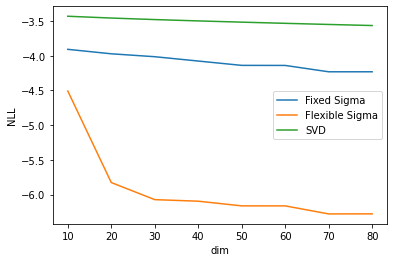

In [17]:
plt.plot(dims,res_fix,label="Fixed Sigma")
plt.plot(dims,res_flex,label="Flexible Sigma")
plt.plot(dims,res_svd,label="SVD")
plt.xlabel("dim")
plt.ylabel("NLL")
plt.legend()